# Creating The Model

## 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Import Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 3. Check GPU Availability

In [3]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 4. Dataset Paths & Params

In [4]:
data_dir = "/content/drive/My Drive/My_Plant_Proj/Dataset/Dataset"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"

IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
MAX_PER_CLASS = 180  # 180 images per class

## 5. Function to Limit Images per Class

In [5]:
def get_limited_image_paths(directory, max_per_class=180):
    image_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            all_images = sorted(os.listdir(class_path))
            selected_images = all_images[:max_per_class]
            for img in selected_images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    return pd.DataFrame({"filename": image_paths, "class": labels})

## 6. Create DataFrames

In [6]:
train_df = get_limited_image_paths(train_dir, MAX_PER_CLASS)
valid_df = get_limited_image_paths(valid_dir, MAX_PER_CLASS)

print("Train Class Distribution:\n", train_df['class'].value_counts())
print("Validation Class Distribution:\n", valid_df['class'].value_counts())

Train Class Distribution:
 class
Apple___Apple_scab                                    180
Corn_(maize)___healthy                                180
Blueberry___healthy                                   180
Grape___Black_rot                                     180
Peach___healthy                                       180
Orange___Haunglongbing_(Citrus_greening)              180
Apple___Cedar_apple_rust                              180
Cherry_(including_sour)___Powdery_mildew              180
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            180
Pepper,_bell___healthy                                180
Cherry_(including_sour)___healthy                     180
Corn_(maize)___Common_rust_                           180
Grape___Esca_(Black_Measles)                          180
Grape___healthy                                       180
Peach___Bacterial_spot                                180
Corn_(maize)___Northern_Leaf_Blight                   180
Pepper,_bell___Bacterial_spot          

## 7. Data Generators with EfficientNet Preprocessing

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

Found 3599 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 3600 validated image filenames belonging to 20 classes.


## 8. Define EfficientNetB0 Model

In [8]:
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base initially

# Optionally unfreeze last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

Number of classes: 20
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 9. Compile Model

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,075,191 (15.55 MB)

 Trainable params: 1,376,580 (5.25 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

## 10. Callbacks

In [10]:
checkpoint = ModelCheckpoint(
    "/content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5",
    monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6, verbose=1
)

## 11. Train Model

In [11]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.5961 - loss: 1.5728 
Epoch 1: val_accuracy improved from -inf to 0.87306, saving model to /content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4995s 88s/step - accuracy: 0.5995 - loss: 1.5604 - val_accuracy: 0.8731 - val_loss: 0.3961 - learning_rate: 5.0000e-04
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9651 - loss: 0.1375
Epoch 2: val_accuracy improved from 0.87306 to 0.94639, saving model to /content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - accuracy: 0.9652 - loss: 0.1371 - val_accuracy: 0.9464 - val_loss: 0.1699 - learning_rate: 5.0000e-04
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9928 - loss: 0.0490
Epoch 3: val_accuracy improved from 0.94639 to 0.96167, saving model to /content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - accuracy: 0.9928 - loss: 0.0489 - val_accuracy: 0.9617 - val_loss: 0.1289 - learning_rate: 5.0000e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9961 - loss: 0.0289
Epoch 4: val_accuracy did not improve from 0.96167
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 588ms/step - accuracy: 0.9961 - loss: 0.0289 - val_accuracy: 0.9558 - val_loss: 0.1317 - learning_rate: 5.0000e-04
Epoch 5/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9982 - loss: 0.0191
Epoch 5: val_accuracy improved from 0.96167 to 0.96667, saving model to /content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 469ms/step - accuracy: 0.9982 - loss: 0.0191 - val_accuracy: 0.9667 - val_loss: 0.1038 - learning_rate: 5.0000e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9964 - loss: 0.0184
Epoch 6: val_accuracy did not improve from 0.96667
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - accuracy: 0.9964 - loss: 0.0184 - val_accuracy: 0.9639 - val_loss: 0.1207 - learning_rate: 5.0000e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9983 - loss: 0.0127
Epoch 7: val_accuracy improved from 0.96667 to 0.96917, saving model to /content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 462ms/step - accuracy: 0.9983 - loss: 0.0127 - val_accuracy: 0.9692 - val_loss: 0.0977 - learning_rate: 5.0000e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9986 - loss: 0.0101
Epoch 8: val_accuracy did not improve from 0.96917
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.9986 - loss: 0.0101 - val_accuracy: 0.9669 - val_loss: 0.1096 - learning_rate: 5.0000e-04
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9967 - loss: 0.0137
Epoch 9: val_accuracy did not improve from 0.96917

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - accuracy: 0.9967 - loss: 0.0136 - val_accuracy: 0.9631 - val_loss: 0.1225 - learning_rate: 5.0000e-04
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9979 - loss: 0.0108
Epoch 10: val_accuracy did not improve from 0.96917
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 436ms/step - accuracy: 0.9979 - loss: 0.0

## 12. Save Final Model

In [12]:
# model.save("/content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_final.h5")

# Result and Graphical Visualisation

In [13]:
plt.style.use("ggplot")

colors = ["#ff6361", "#bc5090", "#ffa600", "#58508d", "#003f5c", "#44bd32"]

plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

## 1. Accuracy Plot

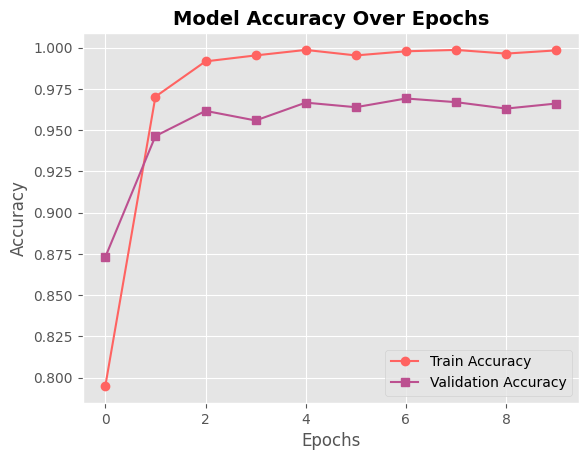

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color=colors[0])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color=colors[1])
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

## 2. Loss Plot

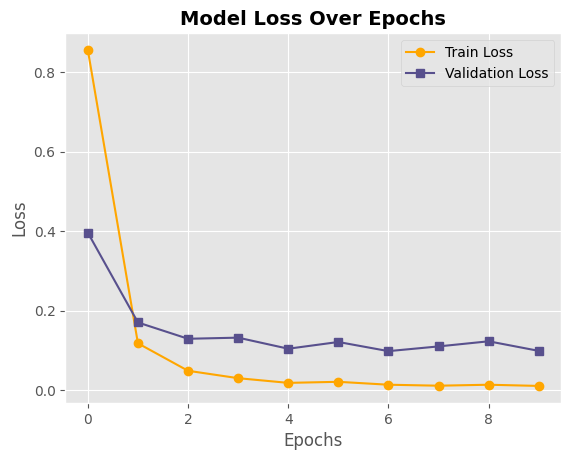

In [15]:
plt.plot(history.history['loss'], label='Train Loss', marker='o', color=colors[2])
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color=colors[3])
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## 3. Train vs. Validation Loss Difference

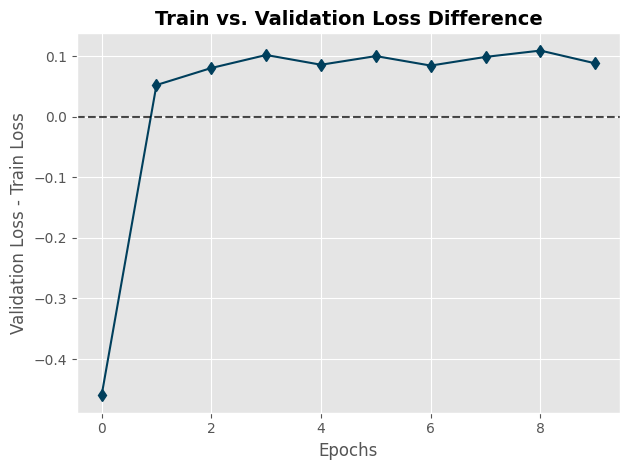

In [16]:
loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
plt.plot(loss_diff, marker='d', color=colors[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('Train vs. Validation Loss Difference', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss - Train Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Class Distribution in Training Data

<ipython-input-17-f0633d94371b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


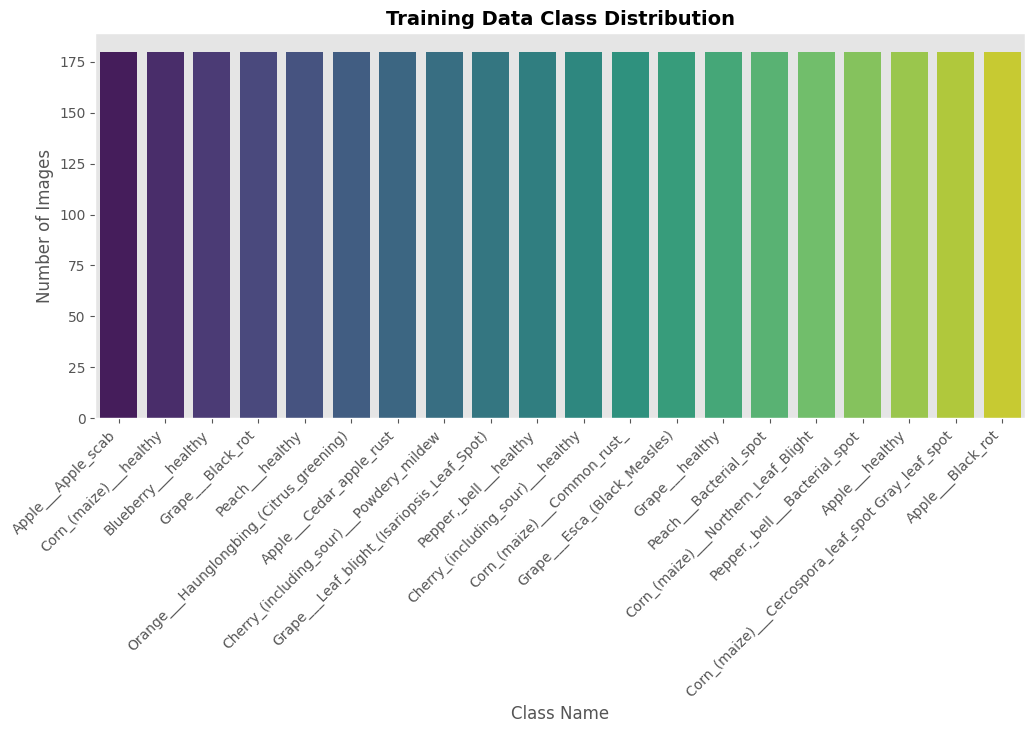

In [17]:
plt.figure(figsize=(12, 5))
class_counts = train_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Training Data Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

## 5. Confusion Matrix

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 308ms/step


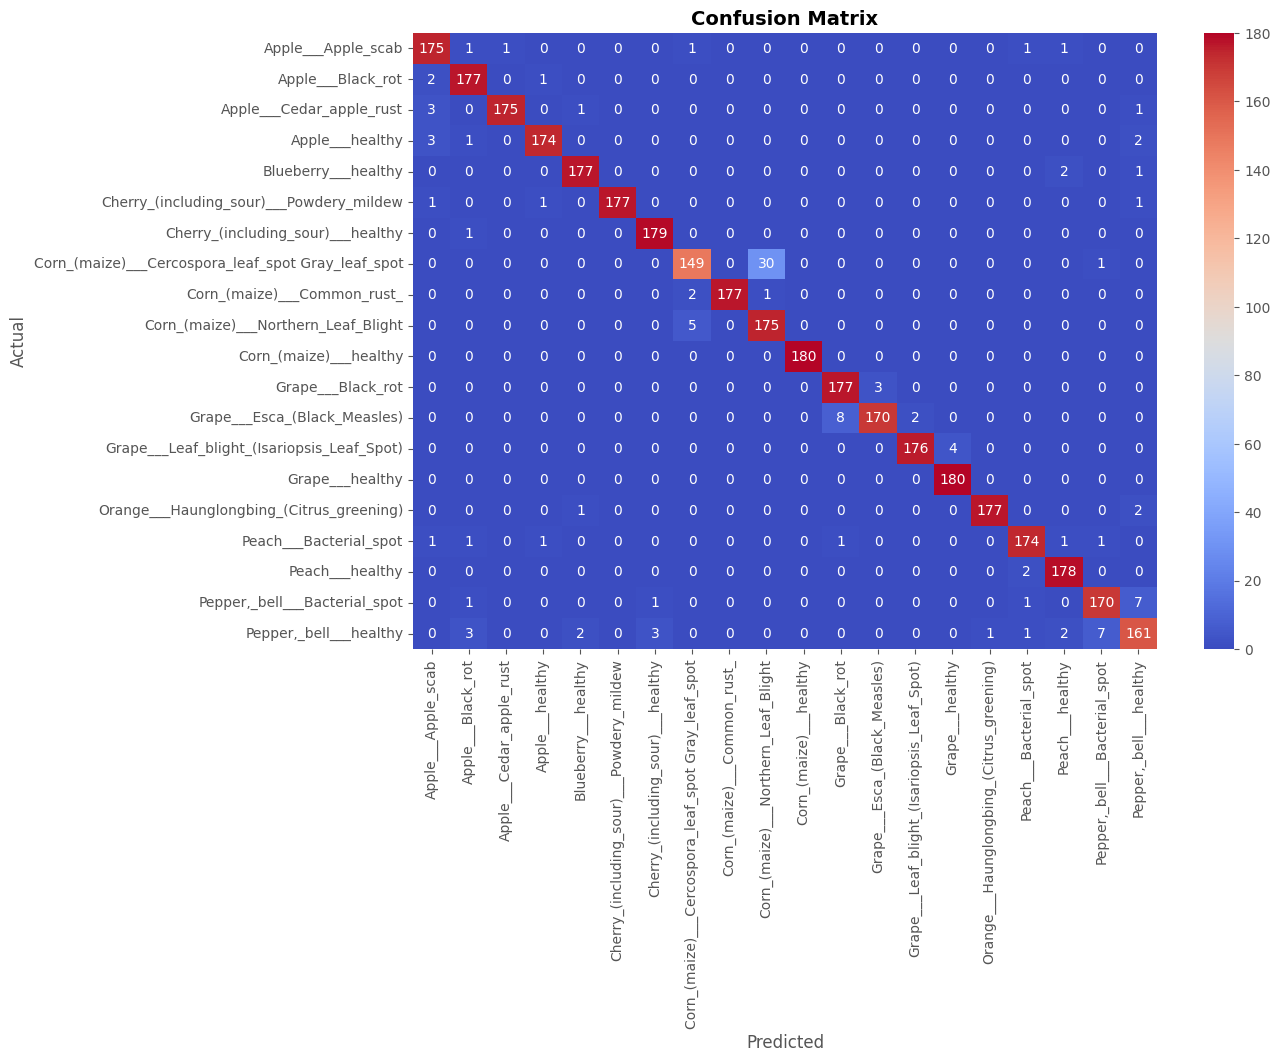

In [18]:
y_true = valid_generator.classes
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()
